In [1]:
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pydicom

In [2]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x) 
    return (x * 255).astype("uint8")


def load_dicom_stack(dicom_folder, plane, reverse_sort=False):
    dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))
    dicoms = [pydicom.dcmread(f) for f in dicom_files]
    plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]
    positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])
    # if reverse_sort=False, then increasing array index will be from RIGHT->LEFT and CAUDAL->CRANIAL
    # thus we do reverse_sort=True for axial so increasing array index is craniocaudal
    idx = np.argsort(-positions if reverse_sort else positions)
    ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
    array = np.stack([d.pixel_array.astype("float32") for d in dicoms])
    array = array[idx]
    return {"array": convert_to_8bit(array), "positions": ipp, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float")}

In [3]:
df = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
study = df.loc[df.study_id == df.study_id.iloc[0]]
study


study_id   series_id series_description
0   4003253   702807833   Sagittal T2/STIR
1   4003253  1054713880        Sagittal T1
2   4003253  2448190387           Axial T2

In [4]:
image_dir = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/"

for row in study.itertuples():
    if row.series_description == "Sagittal T2/STIR":
        sag_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
    elif row.series_description == "Sagittal T1":
        sag_t1 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
    elif row.series_description == "Axial T2":
        ax_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="axial", reverse_sort=True)

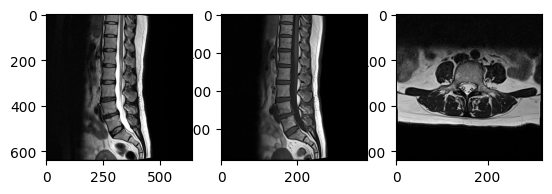

In [5]:
plt.subplot(1, 3, 1)
plt.imshow(sag_t2["array"][len(sag_t2["array"]) // 2], cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(sag_t1["array"][len(sag_t1["array"]) // 2], cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(ax_t2["array"][len(ax_t2["array"]) // 2], cmap="gray")
plt.show()

In [6]:
top_left_hand_corner_sag_t2 = sag_t2["positions"][len(sag_t2["array"]) // 2]
top_left_hand_corner_sag_t2

array([   1.717877,  -76.64711 , -282.82373 ])

In [7]:
sag_y_axis_to_pixel_space = [top_left_hand_corner_sag_t2[2]]
while len(sag_y_axis_to_pixel_space) < sag_t2["array"].shape[1]: 
    sag_y_axis_to_pixel_space.append(sag_y_axis_to_pixel_space[-1] - sag_t2["pixel_spacing"][1])
    # Coordinates DECREASE (i.e. become more negative) from HEAD to TOE


In [8]:
sag_y_coord_to_axial_slice = {}
for ax_t2_slice, ax_t2_pos in zip(ax_t2["array"], ax_t2["positions"]):
    diffs = np.abs(np.asarray(sag_y_axis_to_pixel_space) - ax_t2_pos[2])
    sag_y_coord = np.argmin(diffs)
    sag_y_coord_to_axial_slice[sag_y_coord] = ax_t2_slice

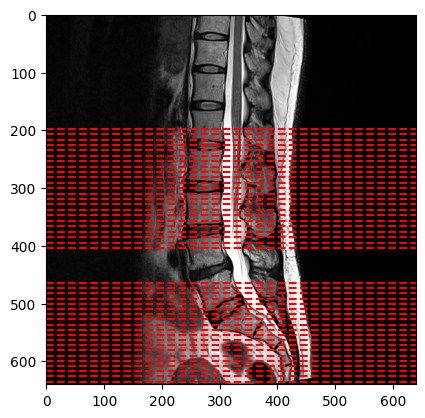

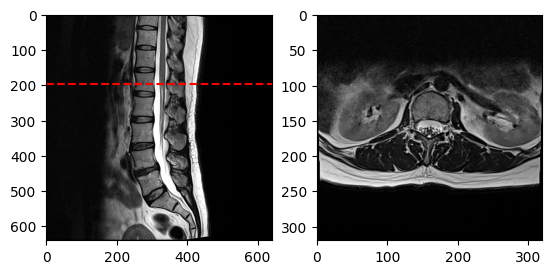

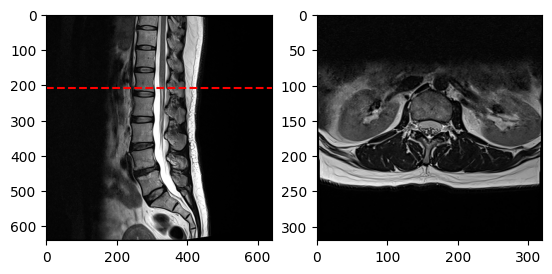

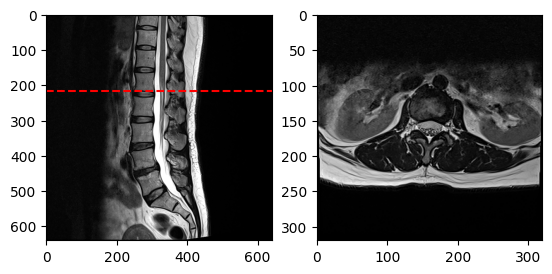

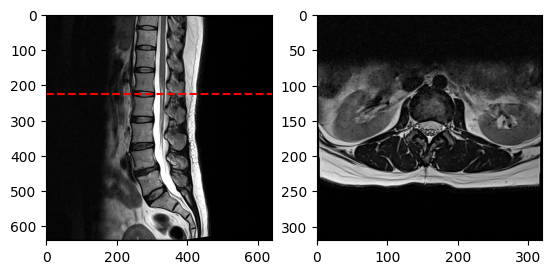

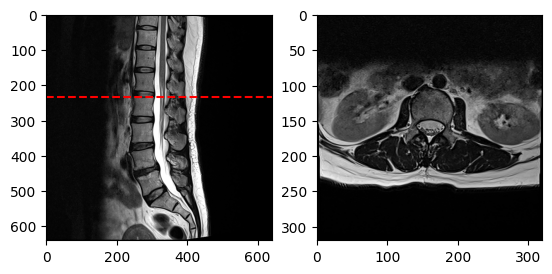

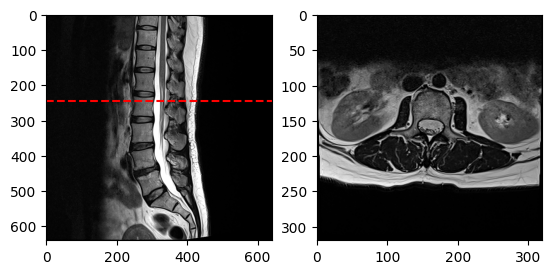

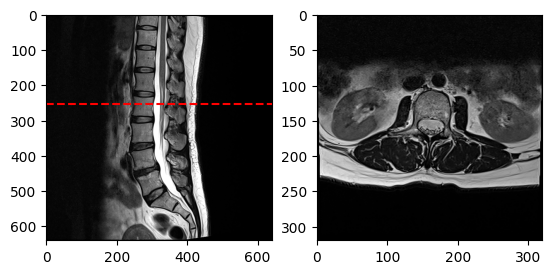

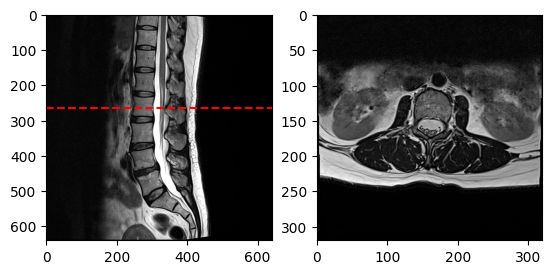

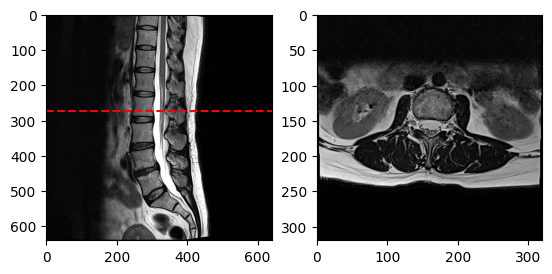

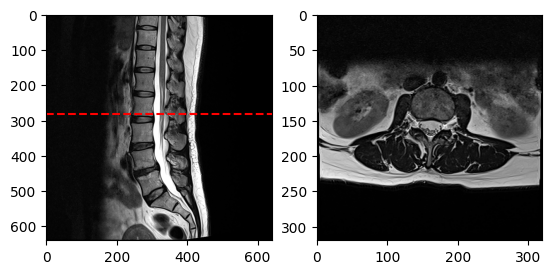

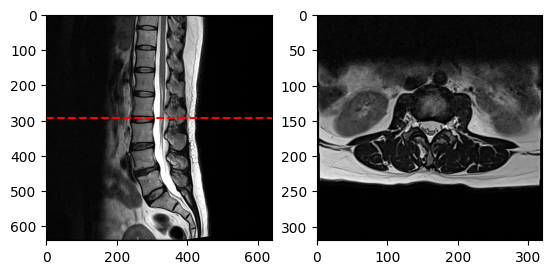

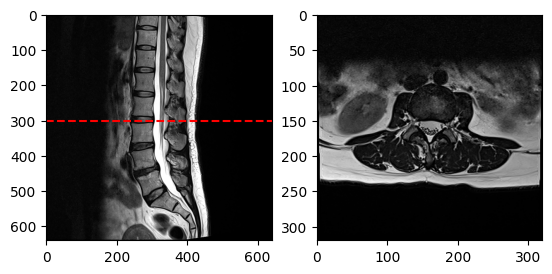

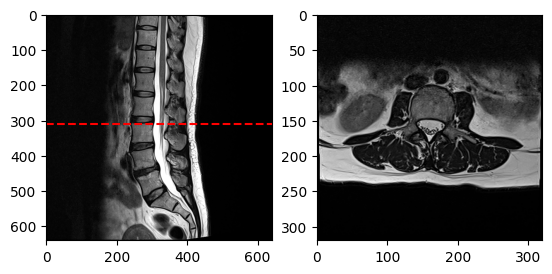

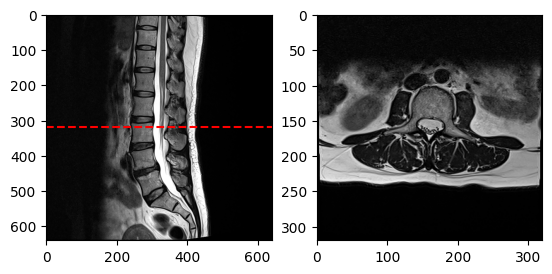

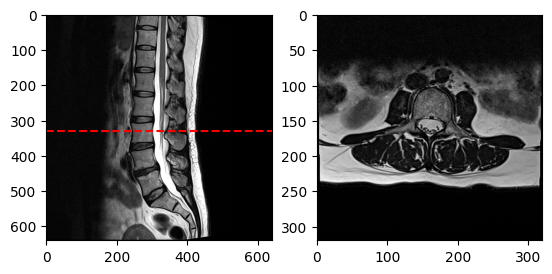

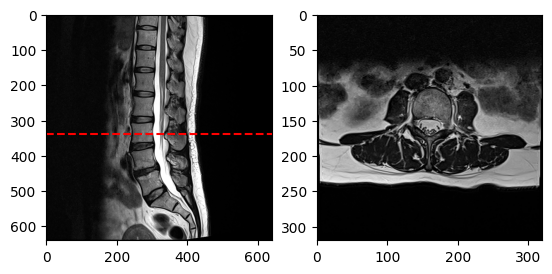

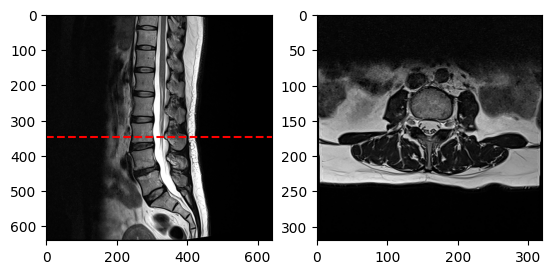

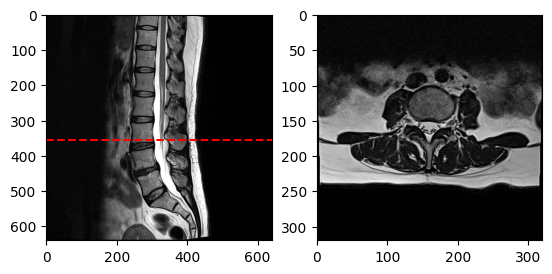

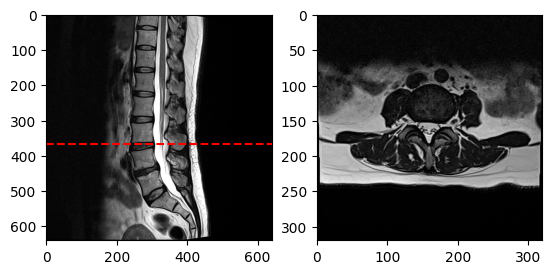

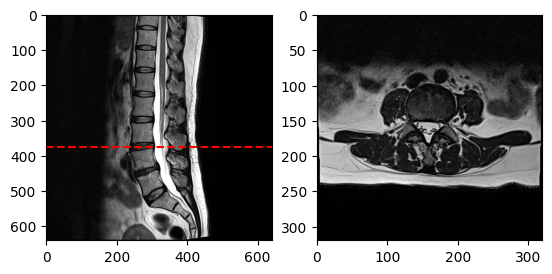

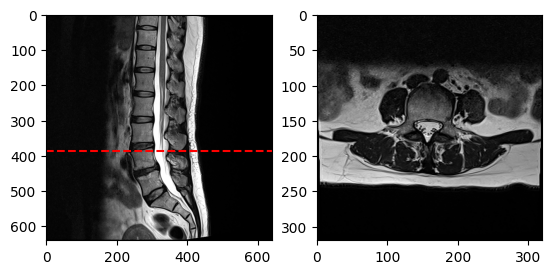

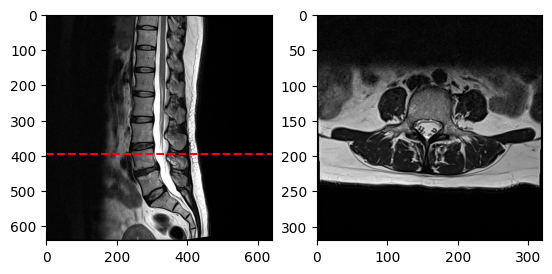

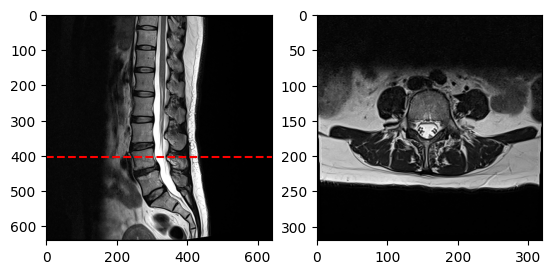

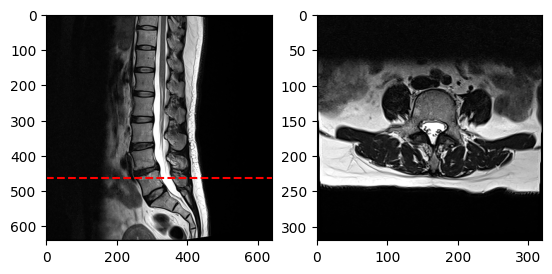

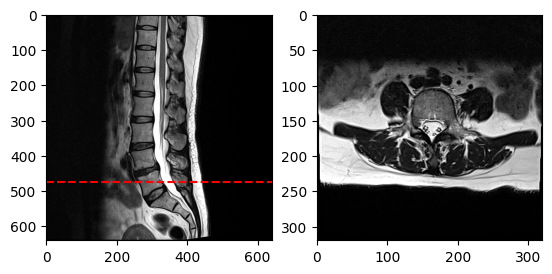

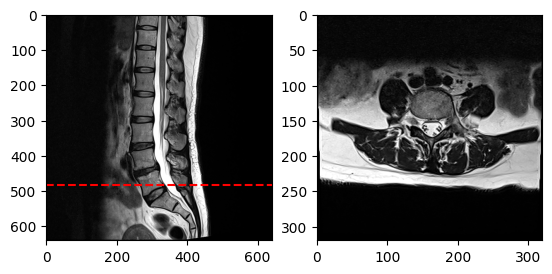

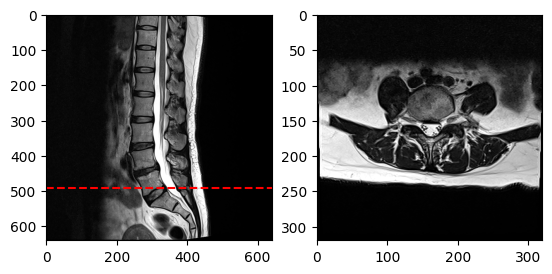

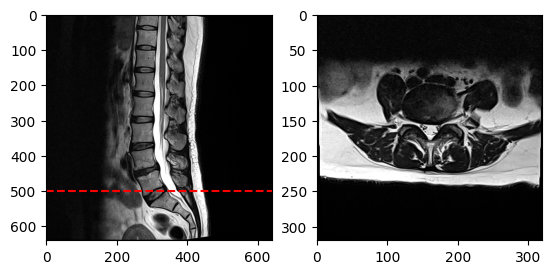

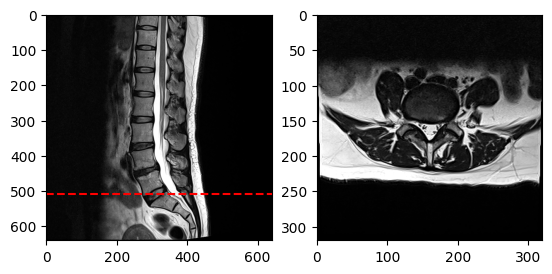

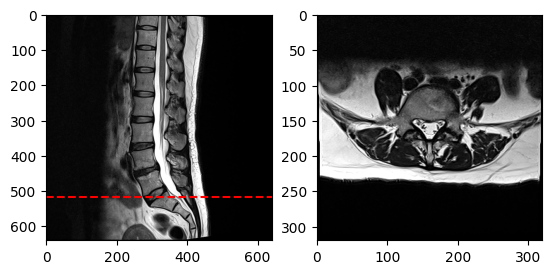

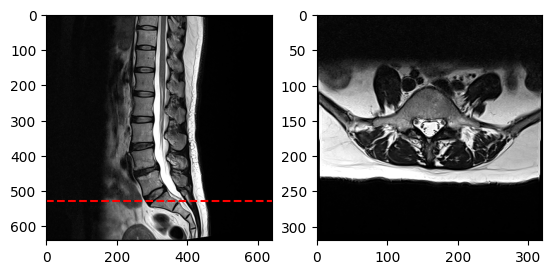

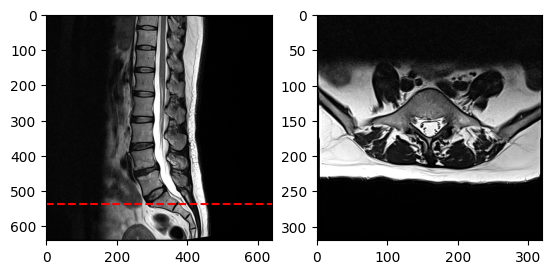

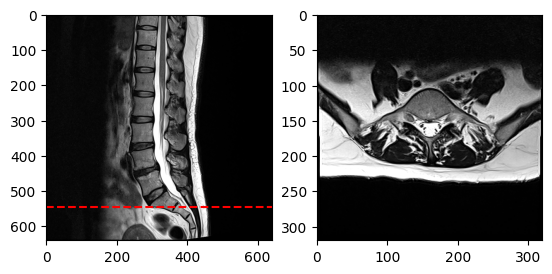

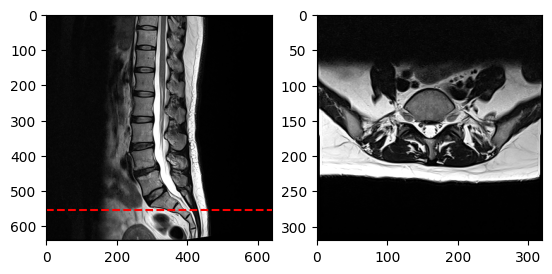

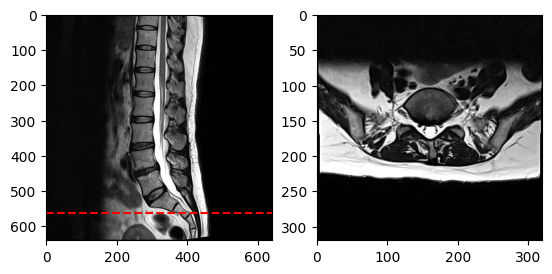

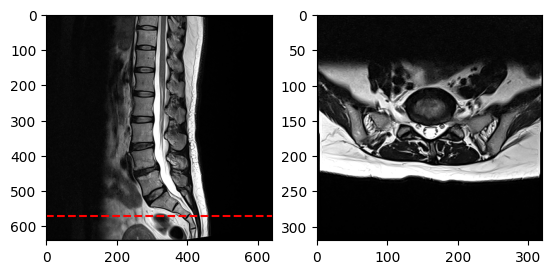

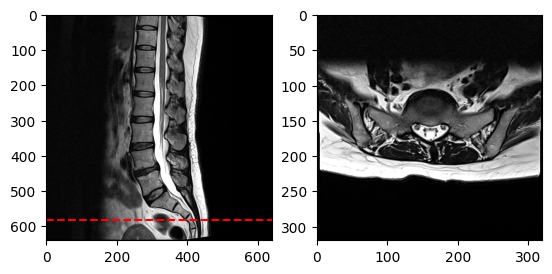

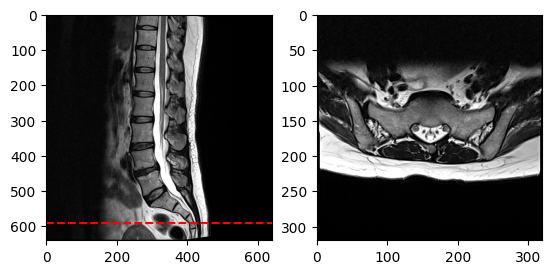

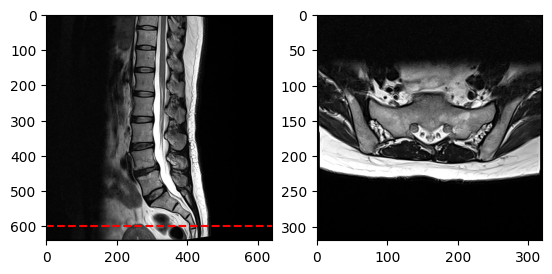

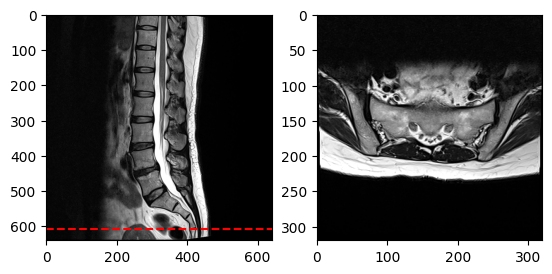

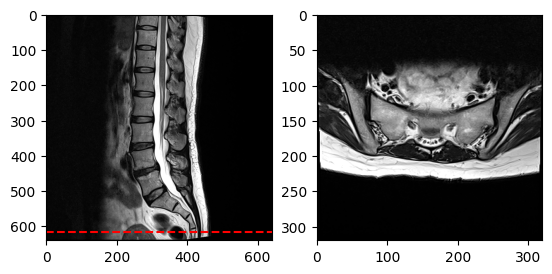

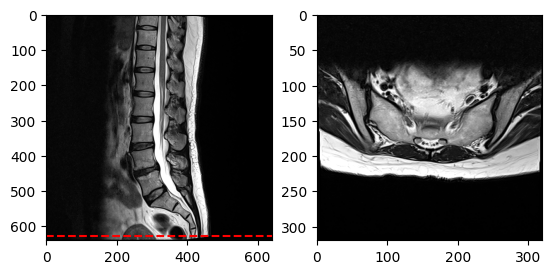

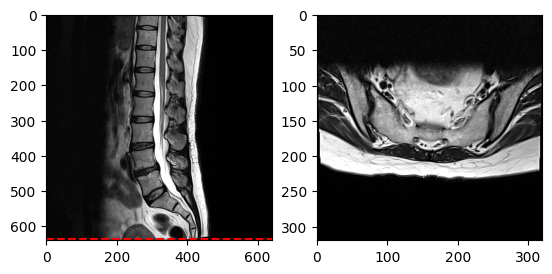

In [9]:
sag_midline_slice = sag_t2["array"][len(sag_t2["array"]) // 2]
plt.imshow(sag_midline_slice, cmap="gray")
for k in [*sag_y_coord_to_axial_slice]: 
    plt.axhline(y=k, color="red", linestyle="--")

plt.show()

for k, v in sag_y_coord_to_axial_slice.items():
    plt.subplot(1, 2, 1)
    plt.imshow(sag_midline_slice, cmap="gray")
    plt.axhline(y=k, color="red", linestyle="--")
    plt.subplot(1, 2, 2)
    plt.imshow(v, cmap="gray")
    plt.show()

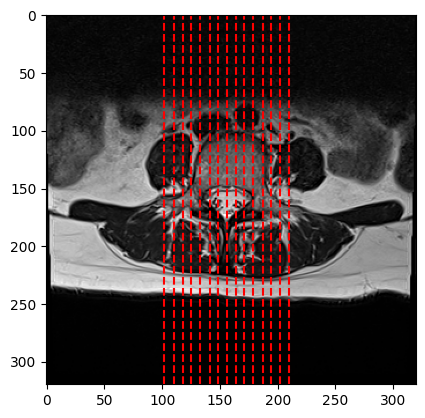

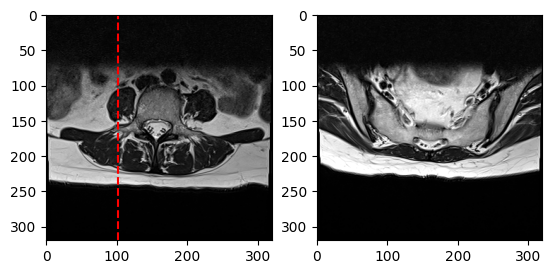

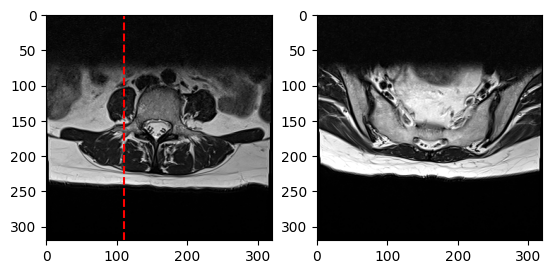

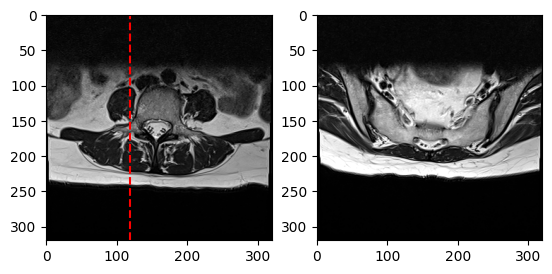

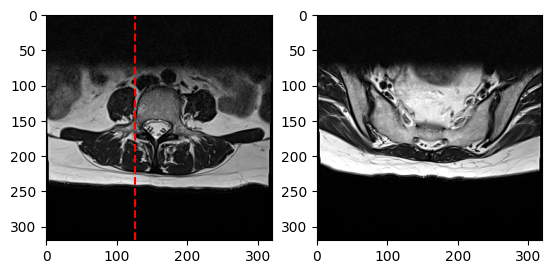

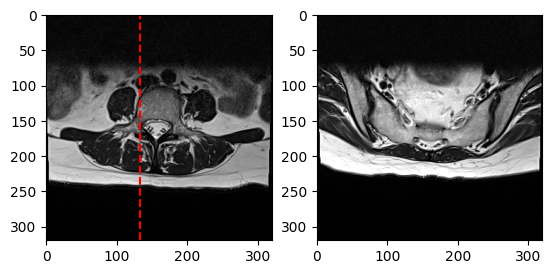

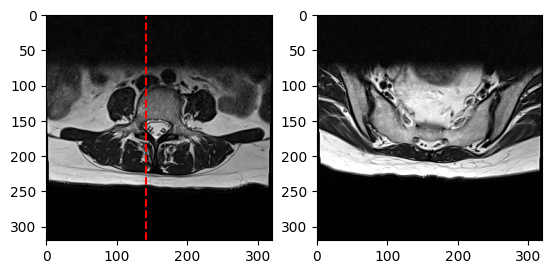

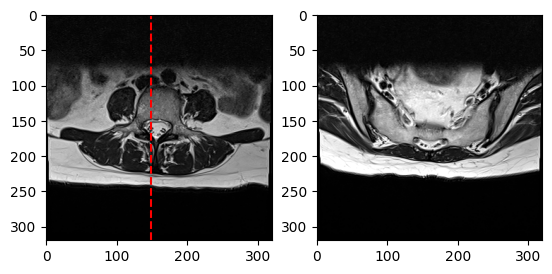

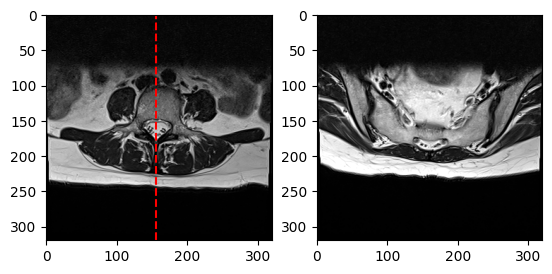

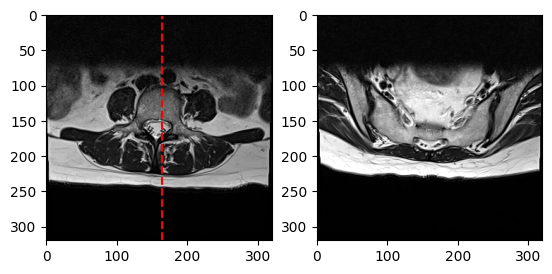

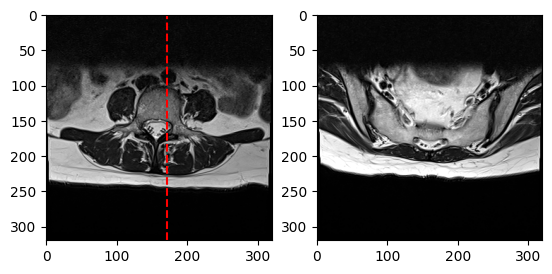

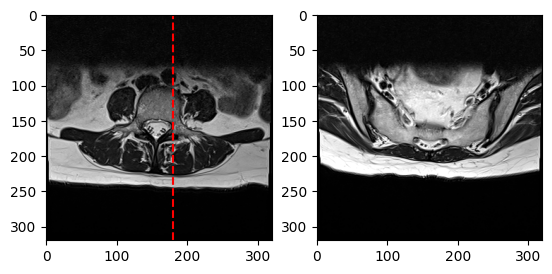

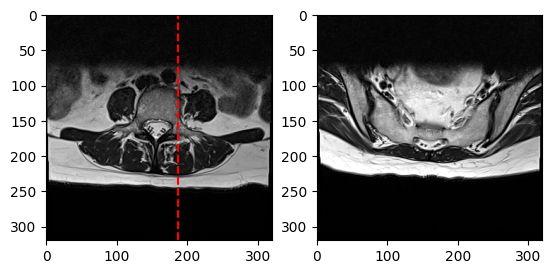

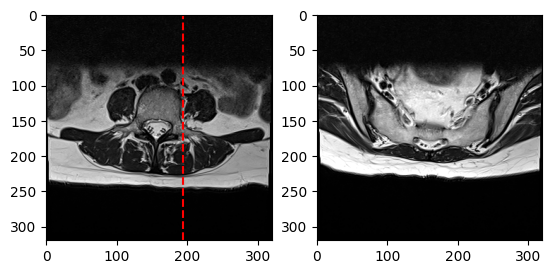

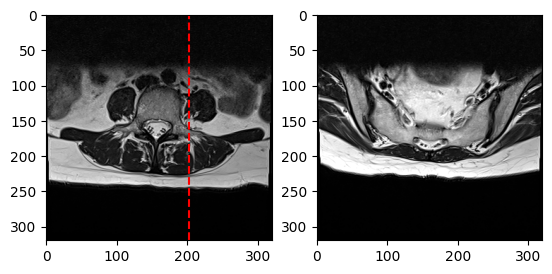

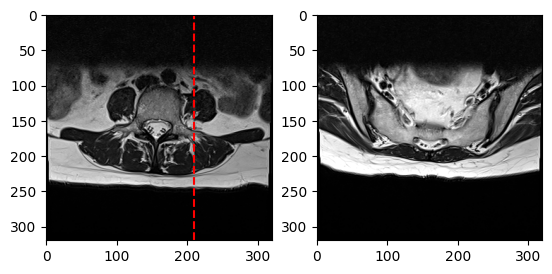

In [10]:
top_left_hand_corner_ax_t2 = ax_t2["positions"][len(ax_t2["array"]) // 2]
top_left_hand_corner_ax_t2

ax_x_axis_to_pixel_space = [top_left_hand_corner_ax_t2[0]]
while len(ax_x_axis_to_pixel_space) < ax_t2["array"].shape[2]: 
    ax_x_axis_to_pixel_space.append(ax_x_axis_to_pixel_space[-1] + ax_t2["pixel_spacing"][0])
    # **NOTE: Coordinates INCREASE (i.e. become more positive) from RIGHT to LEFT

ax_x_coord_to_sag_slice = {}
for sag_t2_slice, sag_t2_pos in zip(sag_t2["array"], sag_t2["positions"]):
    diffs = np.abs(np.asarray(ax_x_axis_to_pixel_space) - sag_t2_pos[0])
    ax_x_coord = np.argmin(diffs)
    ax_x_coord_to_sag_slice[ax_x_coord] = ax_t2_slice
    
mid_ax_slice = ax_t2["array"][len(ax_t2["array"]) // 2]
plt.imshow(mid_ax_slice, cmap="gray")
for k in [*ax_x_coord_to_sag_slice]: 
    plt.axvline(x=k, color="red", linestyle="--")

plt.show()

for k, v in ax_x_coord_to_sag_slice.items():
    plt.subplot(1, 2, 1)
    plt.imshow(mid_ax_slice, cmap="gray")
    plt.axvline(x=k, color="red", linestyle="--")
    plt.subplot(1, 2, 2)
    plt.imshow(v, cmap="gray")
    plt.show()

In [11]:
submission_data = []
for sag_y_coord, ax_t2_slice in sag_y_coord_to_axial_slice.items():
    submission_data.append({
        "sagittal_y_coord": sag_y_coord,
        "axial_slice": ax_t2_slice.mean()
    })

for ax_x_coord, sag_t2_slice in ax_x_coord_to_sag_slice.items():
    submission_data.append({
        "axial_x_coord": ax_x_coord,
        "sagittal_slice": sag_t2_slice.mean()
    })

submission_df = pd.DataFrame(submission_data)

# Save to CSV
submission_df.to_csv("submission.csv", index=False)
